In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
from torchvision import datasets, transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Function to load models
def load_model(model_name, weight_path, num_classes=3):
    if model_name == 'squeezenet':
        model = models.squeezenet1_1(pretrained=False)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
    elif model_name == 'resnet':
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=False)
        model.classifier[6] = nn.Linear(4096, num_classes)
    
    model.load_state_dict(torch.load(weight_path, map_location=device))
    return model.to(device).eval()


In [6]:
# Load trained models
models_dict = {
    'SqueezeNet': load_model('squeezenet', 'trained_squeezenet_2.pth'),
    'ResNet18': load_model('resnet', 'trained_resnet5.pth'),
    'AlexNet': load_model('alexnet', 'trained_alexnet5.pth')
}

# Define transformations
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:

# Load dataset
DatasetPath = 'ecgdataset'
dataset = datasets.ImageFolder(root=DatasetPath, transform=val_transform)
val_loader = DataLoader(dataset, batch_size=20, shuffle=False)


In [8]:

# Function to get probability predictions
def get_probabilities(model, loader):
    probs = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = nn.functional.softmax(model(inputs), dim=1)  # Convert logits to probabilities
            probs.extend(outputs.cpu().numpy())
    return np.array(probs)

In [9]:
# Get probability predictions from each model
all_probs = {name: get_probabilities(model, val_loader) for name, model in models_dict.items()}


In [10]:
# Get true labels
true_labels = np.array([label for _, labels in val_loader for label in labels.numpy()])

In [11]:
# Prepare training data for meta-classifier (stacked features)
X_train = np.hstack([all_probs['SqueezeNet'], all_probs['ResNet18'], all_probs['AlexNet']])  # Concatenate probabilities
y_train = true_labels  # True labels

In [12]:
# Train logistic regression as meta-classifier
meta_classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
meta_classifier.fit(X_train, y_train)

c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [13]:

# Make final predictions using meta-classifier
ensemble_preds = meta_classifier.predict(X_train)

In [14]:

# Compute accuracy
individual_acc = {model: accuracy_score(true_labels, np.argmax(probs, axis=1)) for model, probs in all_probs.items()}
ensemble_acc = accuracy_score(true_labels, ensemble_preds)

In [15]:
# Plot results
plt.figure(figsize=(6,6))

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

([0, 1, 2, 3],
 [Text(0, 0, 'SqueezeNet'),
  Text(1, 0, 'ResNet18'),
  Text(2, 0, 'AlexNet'),
  Text(3, 0, 'Ensemble')])

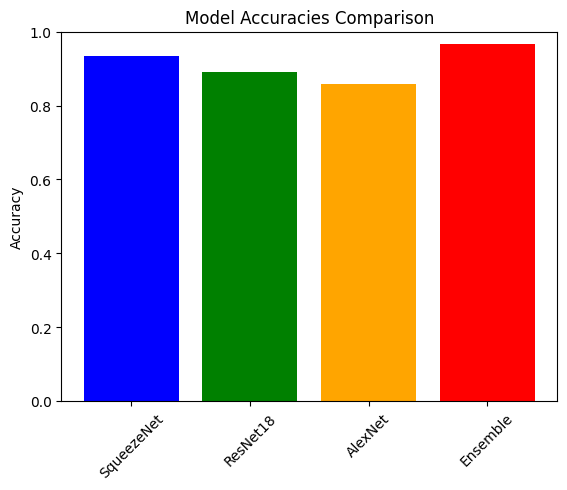

In [16]:
# Plot 1: Model Comparison
# plt.subplot(1, 3, 1)
models = list(individual_acc.keys()) + ['Ensemble']
accuracies = list(individual_acc.values()) + [ensemble_acc]
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Accuracies Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

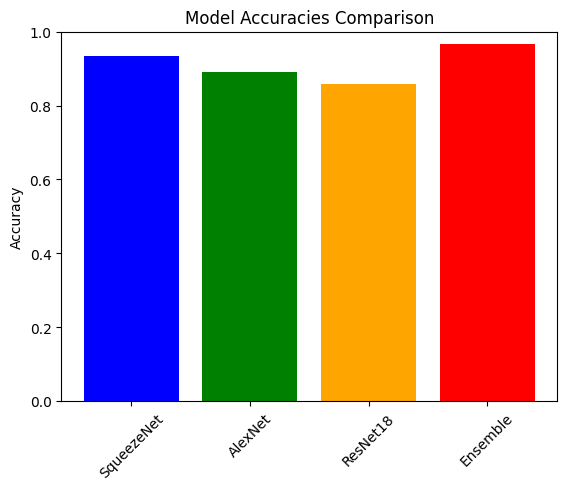

In [17]:
# Plot 1: Model Comparison
models = list(individual_acc.keys()) + ['Ensemble']
# Swap the model names as per your request
models = ['SqueezeNet', 'AlexNet','ResNet18' , 'Ensemble']  # Manually reordered
accuracies = list(individual_acc.values()) + [ensemble_acc]

plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Accuracies Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Ensemble Confusion Matrix')

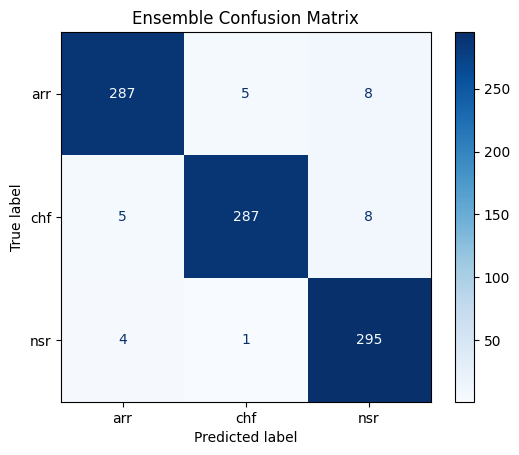

In [18]:
# Plot 2: Confusion Matrix
# plt.subplot(1, 3, 2)
cm = confusion_matrix(true_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
# disp.plot(ax=plt.gca())
disp.plot(cmap=plt.cm.Blues)

plt.title('Ensemble Confusion Matrix')

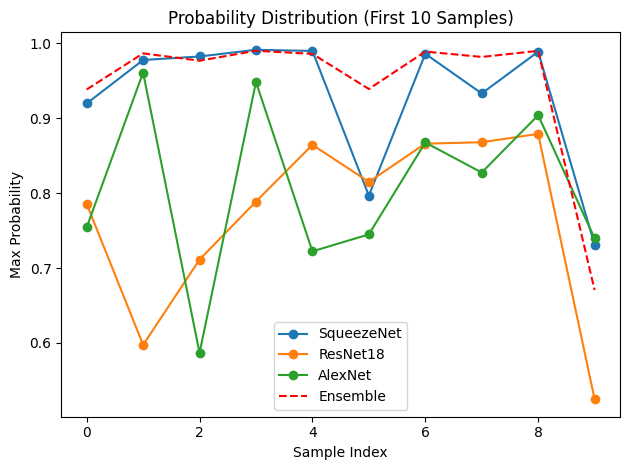

In [22]:

# Plot 3: Probability Distribution (First 10 Samples)
# plt.subplot(1, 3, 3)
sample_probs = np.array([all_probs['SqueezeNet'][:10, :].max(axis=1),
                          all_probs['ResNet18'][:10, :].max(axis=1),
                          all_probs['AlexNet'][:10, :].max(axis=1)])
plt.plot(sample_probs.T, marker='o')
plt.plot(meta_classifier.predict_proba(X_train[:10]).max(axis=1), 'r--', label='Ensemble')
plt.xlabel('Sample Index')
plt.ylabel('Max Probability')
plt.title('Probability Distribution (First 10 Samples)')
plt.legend(['SqueezeNet', 'ResNet18', 'AlexNet', 'Ensemble'])

plt.tight_layout()
plt.show()

In [23]:
print("Individual Model Accuracies:")
for model, acc in individual_acc.items():
    print(f"{model}: {acc:.4f}")
print(f"\nEnsemble Accuracy: {ensemble_acc:.4f}")

Individual Model Accuracies:
SqueezeNet: 0.9644
ResNet18: 0.8867
AlexNet: 0.7978

Ensemble Accuracy: 0.9711


In [25]:
# Lists to store loss and accuracy per epoch
train_losses = []
train_accuracies = []

# Number of epochs
epochs = 20  # Adjust as needed

for epoch in range(epochs):
    # Fit meta-classifier using logistic regression
    meta_classifier.fit(X_train, y_train)
    
    # Get predictions and probabilities
    train_preds = meta_classifier.predict(X_train)
    train_probs = meta_classifier.predict_proba(X_train)
    
    # Compute loss (cross-entropy loss)
    loss = -np.mean(np.log(train_probs[np.arange(len(y_train)), y_train]))  # Cross-entropy loss approximation
    
    # Compute accuracy
    accuracy = accuracy_score(y_train, train_preds)
    
    # Store loss and accuracy
    train_losses.append(loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linea

Epoch 1/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 2/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 3/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 4/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 5/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 6/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 7/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 8/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 9/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 10/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 11/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 12/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 13/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 14/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 15/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 16/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 17/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 18/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 19/20, Loss: 0.0927, Accuracy: 0.9711
Epoch 20/20, Loss: 0.0927, Accuracy: 0.9711


c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linea

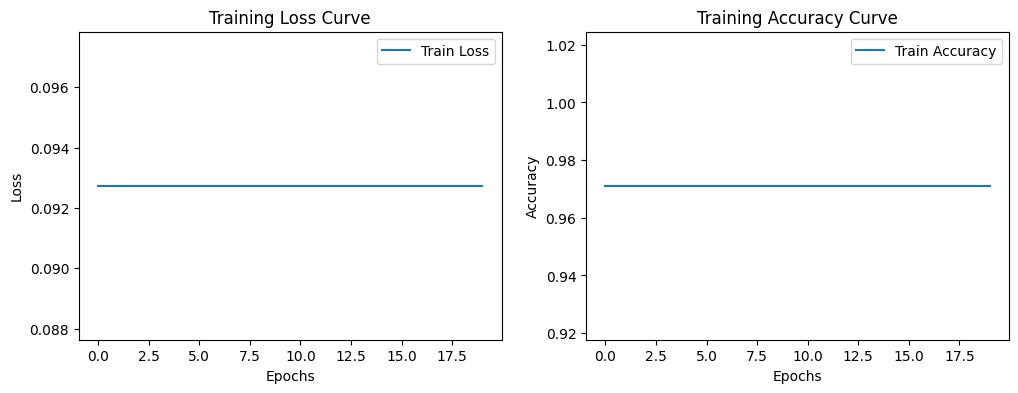

In [26]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Training Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Training Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.show()


c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\AMITOJ SINGH\Desktop\ECG_proj\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 

Epoch 1/17, Loss: 0.6187, Accuracy: 0.9522
Epoch 2/17, Loss: 0.3413, Accuracy: 0.9567
Epoch 3/17, Loss: 0.2051, Accuracy: 0.9578
Epoch 4/17, Loss: 0.1424, Accuracy: 0.9600
Epoch 5/17, Loss: 0.1135, Accuracy: 0.9644
Epoch 6/17, Loss: 0.1076, Accuracy: 0.9633
Epoch 7/17, Loss: 0.1043, Accuracy: 0.9678
Epoch 8/17, Loss: 0.1016, Accuracy: 0.9678
Epoch 9/17, Loss: 0.1001, Accuracy: 0.9689
Epoch 10/17, Loss: 0.0986, Accuracy: 0.9700
Epoch 11/17, Loss: 0.0978, Accuracy: 0.9700
Epoch 12/17, Loss: 0.0969, Accuracy: 0.9700
Epoch 13/17, Loss: 0.0964, Accuracy: 0.9689
Epoch 14/17, Loss: 0.0958, Accuracy: 0.9700
Epoch 15/17, Loss: 0.0954, Accuracy: 0.9700
Epoch 16/17, Loss: 0.0950, Accuracy: 0.9700
Epoch 17/17, Loss: 0.0948, Accuracy: 0.9711


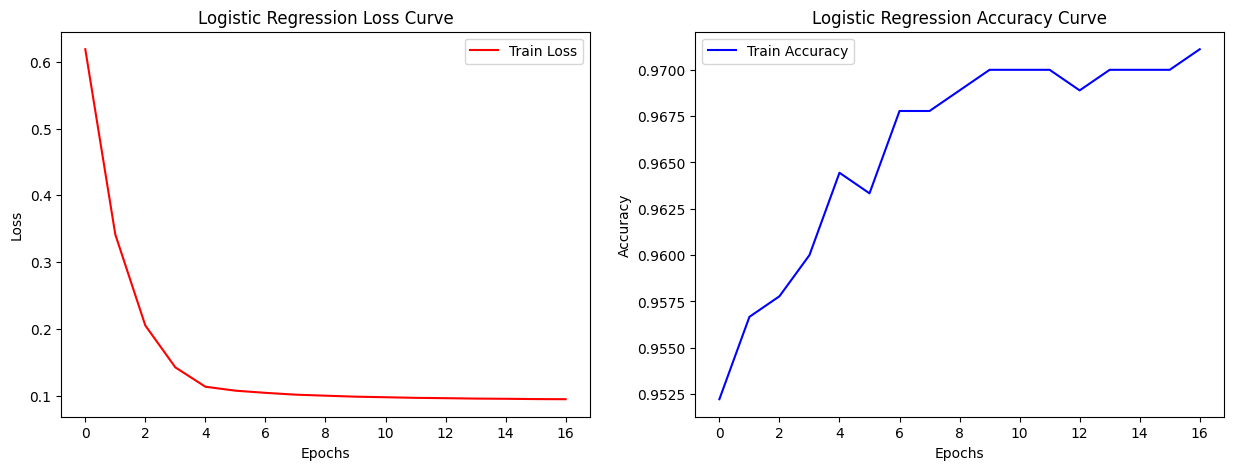

In [36]:
# Enable warm start for iterative training
meta_classifier = LogisticRegression(max_iter=1, solver='lbfgs', multi_class='multinomial', warm_start=True)

train_losses = []
train_accuracies = []

epochs = 17 # Number of iterations

for epoch in range(epochs):
    meta_classifier.fit(X_train, y_train)  # Train for one iteration

    # Get predictions and probabilities
    train_preds = meta_classifier.predict(X_train)
    train_probs = meta_classifier.predict_proba(X_train)
    
    # Compute loss (cross-entropy)
    loss = -np.mean(np.log(train_probs[np.arange(len(y_train)), y_train]))  
    
    # Compute accuracy
    accuracy = accuracy_score(y_train, train_preds)
    
    # Store loss and accuracy
    train_losses.append(loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot learning curves
plt.figure(figsize=(15, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Logistic Regression Loss Curve')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy Curve')
plt.legend()

plt.show()
